# Supplemental Figures

## Setup

### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_scatter_w_best_fit_line,
    format_small_plot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
)
from tabulate import tabulate
import re
import os

## load data

In [2]:
DATA_PATH = "../../data"

In [3]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2.json")
df_contruct_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df = df1.query("r_type != 'Flank-WC'").copy()
df_avg = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_avg.json")
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
# generate natural log of DMS
with np.errstate(divide="ignore"):
    df1["ln_r_data"] = np.log(df1["r_data"])
df1["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# remove outliers
df = df.query("r_data_outlier == False").copy()

df_bp_details = pd.read_csv(f"../../dms_3d_features/resources/csvs/wc_details.csv")
df_bp_details = df_bp_details.query("flanking_pairs == 'YES'")
df_bp_details["ln_r_data"] = np.log(df_bp_details["r_data"])
df_bp_details["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df_pdb = df_pdb.query("r_data_outlier == False").copy()
df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(lambda x: x.replace("&", "_"))

# merge and remove extra pdb res
df_sasa_merge = pd.merge(
    df_pdb, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"]
)
df_sasa_merge = df_sasa_merge.query("not ln_r_data.isnull()")

df_dist = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)

df_wc = df1.query("r_type == 'Flank-WC'").copy()

df_wc.sort_values("ln_r_data", inplace=True, ascending=False)

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/1217702857.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/1217702857.py:23: FutureWarning: A value is

In [4]:
# Filter rows where pdb_path is an empty list
df_no_pdb = df1.query("has_pdbs == False").copy()

# Remove rows where m_token contains 'HELIX'
df_no_pdb = df_no_pdb[~df_no_pdb["m_token"].str.contains("HELIX", na=False)]

# Get unique values of m_sequence
unique_m_sequences = df_no_pdb["m_sequence"].unique()
print("Number of unique m_sequences (after removing HELIX):", len(unique_m_sequences))

# Get unique values of m_token
unique_m_tokens = df_no_pdb["m_token"].unique()
print("Unique m_tokens (after removing HELIX):", unique_m_tokens)

Number of unique m_sequences (after removing HELIX): 536
Unique m_tokens (after removing HELIX): ['1x1' '2x2']


## Extra functions

In [5]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

In [6]:
def get_dataframe_with_specific_data_values(
    df_construct: pd.DataFrame, df_construct_2, value: float
) -> pd.DataFrame:
    """
    Merges two DataFrames on the 'name' column and filters for rows where both 'data' values are less than 0.001.

    This function takes two DataFrames, each containing 'name' and 'data' columns, and merges them on the 'name' column.
    It then compares the 'data' values from both DataFrames row by row, selecting only the pairs where both values are less
    than 0.001. The result is a new DataFrame with the filtered 'data_1' and 'data_2' columns.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            if d1 < value and d2 < value:
                data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

In [7]:
def plot_feature_scatterplots(df, feature_columns, target_column) -> None:
    """
    Plots scatter plots for each feature against the target variable, including best fit lines and R^2 values.

    This function creates a grid of scatter plots where each plot corresponds to a feature from the
    `feature_columns` plotted against the `target_column`. For each plot, a linear regression line
    is fitted and displayed, along with the R^2 value as an annotation.

    Args:
        df (pandas.DataFrame): The input dataframe containing the features and target column.
        feature_columns (list): A list of column names representing the features to be plotted.
        target_column (str): The name of the target column against which each feature is plotted.
    """
    n_features = len(feature_columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
    for idx, feature in enumerate(feature_columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        ax.scatter(df[target_column], df[feature], s=1)

        # Reshape x for sklearn
        x = np.array(df[target_column]).reshape(-1, 1)
        y = np.array(df[feature])

        # Linear regression model
        model = LinearRegression()
        model.fit(x, y)

        # Get the slope and intercept of the line
        slope = model.coef_[0]
        intercept = model.intercept_

        # Generate x values for the best fit line
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_fit + intercept

        # Plot the best fit line
        ax.plot(x_fit, y_fit, color="black", label="Best fit line", lw=1)

        # Calculate Pearson correlation coefficient and R^2
        r, _ = pearsonr(x.flatten(), y)
        r_squared = r**2

        # Add R^2 annotation
        ax.text(
            0.03,
            0.97,
            f"$R^2 = {r_squared:.3f}$",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment="top",
        )
        ax.set_ylabel(feature.capitalize())
        ax.set_xlabel("ln(Mut. Frac.)")

    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

In [8]:
def calculate_sasa_percentages(df_non_wc_pair, sasa_thresholds=[2]):
    results = []
    for threshold in sasa_thresholds:
        below_threshold = (
            df_non_wc_pair[df_non_wc_pair["sasa_0_5"] < threshold].groupby("cat").size()
        )
        total = df_non_wc_pair.groupby("cat").size()
        percentage = (below_threshold / total * 100).round(2)

        results.append(percentage.rename(f"Percent_below_{threshold}"))

    result_df = pd.concat(results, axis=1).fillna(0)
    result_df["Count"] = df_non_wc_pair.groupby("cat").size()

    headers = ["Category"] + list(result_df.columns)
    table_data = [[index] + row.tolist() for index, row in result_df.iterrows()]

    return tabulate(table_data, headers=headers, tablefmt="pipe", floatfmt=".2f")

In [9]:
def figure_outlier(df_motif, ax, seq):

    plot_motif_boxplot_stripplot(df_motif, ax=ax)
    for pos in df_motif["r_loc_pos"].unique():

        data_at_pos = df_motif[df_motif["r_loc_pos"] == pos]["r_data"]

        q1 = data_at_pos.quantile(0.25)
        q3 = data_at_pos.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = data_at_pos[
            (data_at_pos < lower_bound) | (data_at_pos > upper_bound)
        ]

        ax.scatter([pos] * len(outliers), outliers, color="magenta", zorder=3, s=3)

    ax.set_xlabel("Residues", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)

    format_small_plot(ax)

# Plotting

## Supplemental Figure 1: Diversity of two-way junctions

Unique values in 'm_token':
['2x1' '3x2' '2x2' '1x1' '1x0' '4x4' '4x1' '3x1' '3x0' '4x2' '4x3' '2x0'
 '3x3' '6x3' '5x2' '5x0' '5x4' '5x1' '5x3']


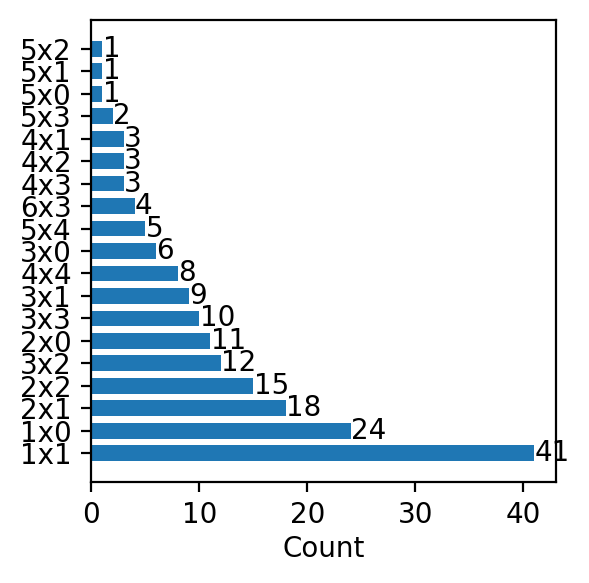

In [10]:
df_1 = df[df["pdb_path"].apply(lambda x: len(x) > 0)]
df_unique = df_1.drop_duplicates(subset=["m_sequence"])
unique_m_tokens = df_unique["m_token"].unique()
print("Unique values in 'm_token':")
print(unique_m_tokens)
m_token_counts = (
    df_unique.groupby("m_token")["m_sequence"]
    .nunique()
    .reset_index()
    .rename(columns={"m_sequence": "count"})
)

m_token_counts = m_token_counts.sort_values(by="count", ascending=False)

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

bars = ax.barh(
    m_token_counts["m_token"],
    m_token_counts["count"],
    height=0.7,
)

ax.set_yticks(range(len(m_token_counts)))
ax.set_yticklabels(m_token_counts["m_token"])
ax.set_xlabel("Count", labelpad=2)

max_count = m_token_counts["count"].max()
label_offset = max_count * 0.001

for bar, count in zip(bars, m_token_counts["count"]):
    ax.text(
        count + label_offset,
        bar.get_y() + bar.get_height() / 2,
        f"{count}",
        va="center",
        ha="left",
    )

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/2657221164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_pdb["m_sequence"] = df_unique_pdb["m_sequence"].str.replace("&", "_")


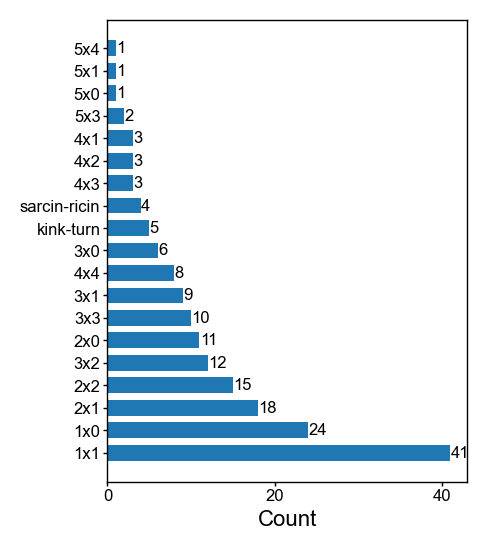

In [11]:
df_avg = df_avg[df_avg["pdb_path"].apply(lambda x: len(x) > 0)]
df_unique_pdb = df_avg.drop_duplicates(subset=["m_sequence"])
df_unique_pdb["m_sequence"] = df_unique_pdb["m_sequence"].str.replace("&", "_")

kt_motifs = ["CGAAGAAC_GGGAG", "CGACGAAG_CAGAG", "CGAUGAAA_UGGAG", "CGAUGAG_CGAG", "CGUUGAAA_UGGAG"]

kink_turn = df_unique_pdb[df_unique_pdb['m_sequence'].isin(kt_motifs)]

df_unique_kt = kink_turn.drop_duplicates(subset=["m_sequence"])
kink_turn_count = len(df_unique_kt)

nucleotide_pattern_srl = re.compile(r"[AGCU]+[AG]+[AU]A[AGCU]+_[AGCU][AG][AU][AGCU]+")

def matches_nucleotide_pattern_srl(sequence):
    return bool(nucleotide_pattern_srl.match(sequence))


def valid_m_token_srl(m_token):
    m_token_pattern = re.compile(r"(\d+)x(\d+)")
    match = m_token_pattern.match(m_token)
    if match:
        num1, num2 = int(match.group(1)), int(match.group(2))
        if (num1 > 3) and (num2 > 3):
            return abs(num1 - num2) == 1
    return False

sarcin_ricin = df_pdb[
    (df_pdb["m_sequence"].apply(matches_nucleotide_pattern_srl))
    & (df_pdb["m_token"].apply(valid_m_token_srl))
]

kink_turn_tokens = kink_turn['m_sequence'].unique()
sarcin_ricin_tokens = sarcin_ricin['m_sequence'].unique()

df_unique_pdb.loc[df_unique_pdb['m_sequence'].isin(kink_turn_tokens), 'm_token'] = "kink-turn"
df_unique_pdb.loc[df_unique_pdb['m_sequence'].isin(sarcin_ricin_tokens), 'm_token'] = "sarcin-ricin"

m_token_counts = (
    df_unique_pdb.groupby("m_token")["m_sequence"]
    .nunique()
    .reset_index()
    .rename(columns={"m_sequence": "count"})
)
m_token_counts = m_token_counts.sort_values(by="count", ascending=False)

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

bars = ax.barh(
    m_token_counts["m_token"],
    m_token_counts["count"],
    height=0.7,
)

ax.set_yticks(range(len(m_token_counts)))
ax.set_yticklabels(m_token_counts["m_token"])
ax.set_xlabel("Count", labelpad=2)

max_count = m_token_counts["count"].max()
label_offset = max_count * 0.001

for bar, count in zip(bars, m_token_counts["count"]):
    ax.text(
        count + label_offset,
        bar.get_y() + bar.get_height() / 2,
        f"{count}",
        va="center",
        ha="left",
    )
format_small_plot(ax)

## Supplemental Figure 2: histogram of number of reads per construct

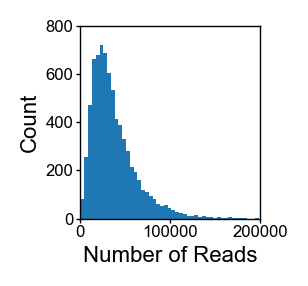

In [12]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plt.hist(df_construct["num_aligned"], bins=100)
ax.set_xlabel("Number of Reads", labelpad=2)
ax.set_ylabel("Count", labelpad=2)
ax.set_xlim([0, 200000])
ax.set_xticks([0, 100000, 200000])
ax.set_yticks(range(0, 1000, 200))
format_small_plot(ax)

## Supplemental Figure 3: DMS correlation between Run 1 and Run 2

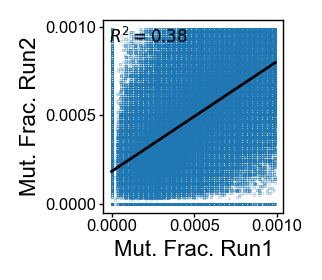

In [13]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = get_dataframe_with_specific_data_values(df_construct, df_construct_2, 0.001)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], size=0.005, ax=ax)
ax.set_xlabel("Mut. Frac. Run1", labelpad=2)
ax.set_ylabel("Mut. Frac. Run2", labelpad=2)
ax.set_xticks([0, 0.0005, 0.001])
ax.set_yticks([0, 0.0005, 0.001])
format_small_plot(ax)

## Supplemental Figure 4: Comparing second flanking pair grouping compared to random

In [14]:
df_fig_1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_fig_1 = df_fig_1.query("r_type != 'WC'").copy()
df_fig_1 = df_fig_1.query("r_data_outlier == False").copy()

with np.errstate(divide="ignore"):
    df_fig_1["ln_r_data"] = np.log(df_fig_1["r_data"])
df_fig_1["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# Group the data and calculate statistics
df_second_stack = (
    df_fig_1.groupby(
        ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
    )
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        m_flank_bp_3p=("m_flank_bp_3p", "first"),
        p5_res=("p5_res", "first"),
        p3_res=("p3_res", "first"),
        r_stack=("r_stack", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        count=("ln_r_data", "count"),
        r_type=("r_type", "first"),
    )
    .reset_index()
)

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/3970814489.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fig_1["ln_r_data"].replace(-np.inf, -9.8, inplace=True)


In [15]:
if not os.path.exists("randomized_cvs.csv"):
    data = []
    for i, row in df_second_stack.query("count >= 5").iterrows():
        df_sub = df.query(
            f"m_sequence == '{row['m_sequence']}' and r_loc_pos == {row['r_loc_pos']}"
        ).sample(row["count"])
        cv = np.std(df_sub["r_data"]) / np.mean(df_sub["r_data"])
        data.append(
            {
                "m_sequence": row["m_sequence"],
                "r_loc_pos": row["r_loc_pos"],
                "cv_r_data": cv,
                "r_type": row["r_type"],
            }
        )
    df_sub = pd.DataFrame(data)
    df_sub.to_csv("randomized_cvs.csv", index=False)
else:
    df_sub = pd.read_csv("randomized_cvs.csv")

In [16]:
df_sub = pd.read_csv("randomized_cvs.csv")

In [17]:
df_cv = (
    df_fig_1.groupby(["m_sequence", "r_loc_pos"])
    .agg(
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        r_type=("r_type", "first"),
    )
    .reset_index()
)
df_cv["data_type"] = "None"
df_second_stack_cv = df_second_stack.query("count >= 5").copy()
df_second_stack_cv["data_type"] = "Second Stack"
df_sub["data_type"] = "Random"
df_all = pd.concat([df_second_stack_cv, df_cv, df_sub]).reset_index(drop=True)

In [18]:
print(
    "average no group WC: "
    + str(df_cv.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average with second WC grouping : "
    + str(df_second_stack_cv.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average with random grouping: "
    + str(df_sub.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average no group NON-WC: "
    + str(df_cv.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)
print(
    "average with second WC grouping : "
    + str(df_second_stack_cv.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)
print(
    "average with random grouping: "
    + str(df_sub.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)

average no group WC: 0.4248140744670936
average with second WC grouping : 0.33967051908293167
average with random grouping: 0.4063811126228333
average no group NON-WC: 0.29662828917958667
average with second WC grouping : 0.2232174827769173
average with random grouping: 0.27747766057579987


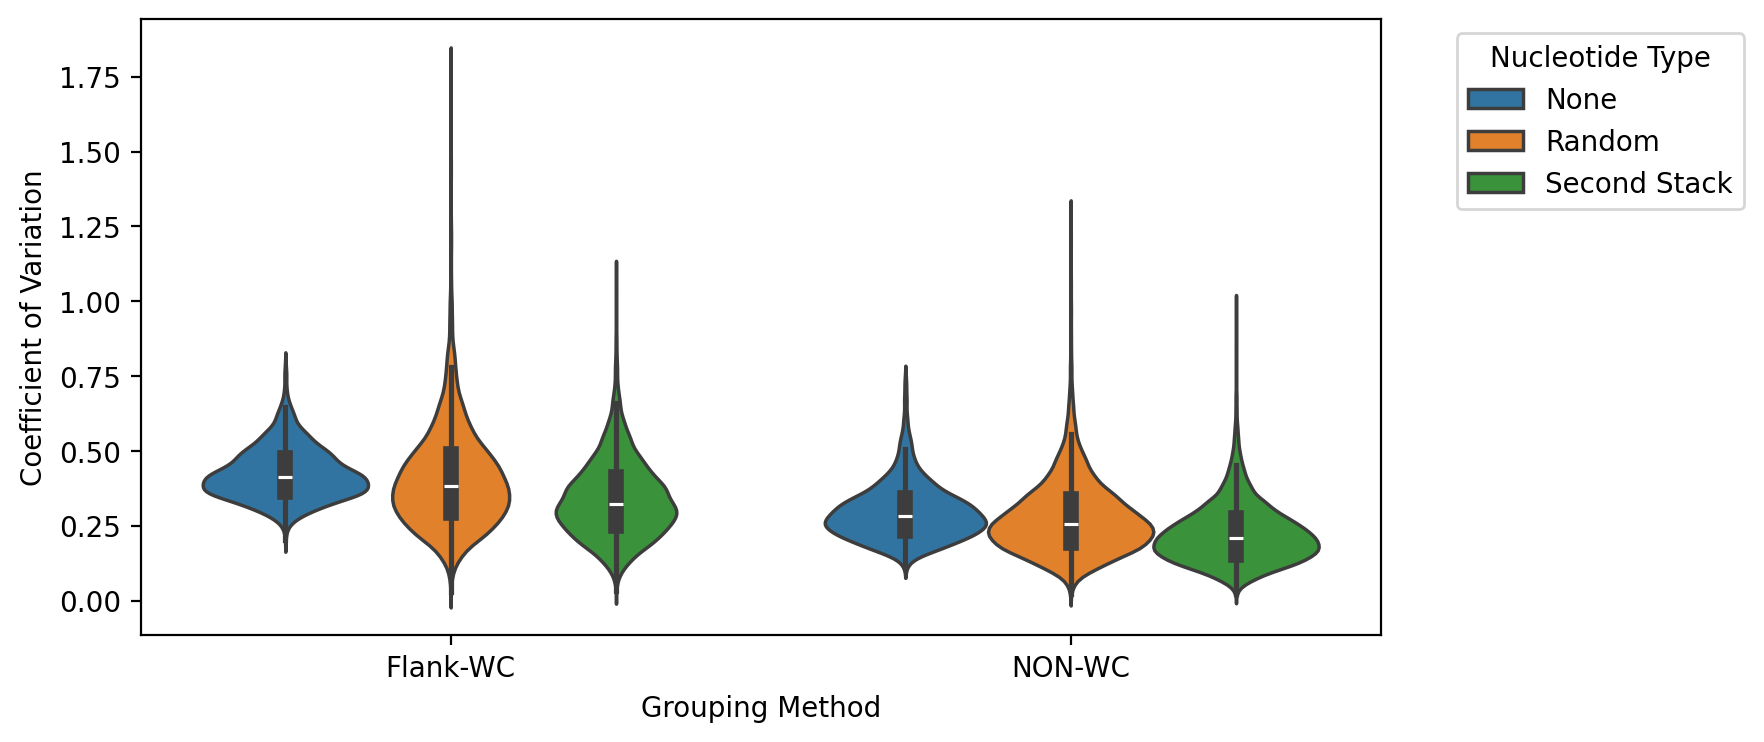

In [21]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

# Create violin plot
sns.violinplot(
    data=df_all,
    x="r_type",
    y="cv_r_data",
    hue="data_type",
    order=["Flank-WC", "NON-WC"],
    hue_order=["None", "Random", "Second Stack"],
    ax=ax,
)

# Customize plot
ax.set_xlabel("Grouping Method")
ax.set_ylabel("Coefficient of Variation")

# Adjust legend
plt.legend(title="Nucleotide Type", bbox_to_anchor=(1.05, 1), loc="upper left")
#plt.savefig(
 #   "../../figures/supplemental_figures/supplemental_figure_4.png",
  #  bbox_inches="tight",
   # dpi=600,
#)

## Supplemental Figure 5: Quantitative analysis of DMS reactivity in WC and non-WC nucleotides  

In [22]:
df1["r_type_simple"] = df1["r_type"].replace("Flank-WC", "WC")

In [23]:
def plot_figure_s5a(df, ax):
    palette = sns.color_palette("tab10", 2)
    ax = sns.violinplot(
        x="ln_r_data",
        y="r_type_simple",
        data=df,
        hue="r_type_simple",
        order=["WC", "NON-WC"],
        ax=ax,
        linewidth=0.5,
        palette=palette[::-1],
    )
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Nucleotide Type", labelpad=2)
    ax.yaxis.set_major_locator(FixedLocator([0, 1, 2]))
    ax.yaxis.set_major_formatter(FixedFormatter(["WC", "Non-\nWC"]))
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

<Axes: xlabel='ln(Mutation Fraction)', ylabel='Nucleotide Type'>

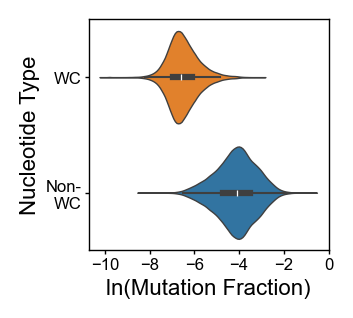

In [24]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_s5a(df1, ax)

In [25]:
def plot_figure_s5b(df, ax):
    df.sort_values("r_type_simple", inplace=True, ascending=True)
    colors = {"WC": "tab:blue", "NON-WC": "tab:orange"}
    # Loop through each unique r_type to plot the cumulative distribution
    for r_type, group_data in df.groupby("r_type_simple"):
        sorted_data = np.sort(group_data["ln_r_data"])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
        ax.plot(sorted_data, cdf, label=r_type, lw=2, color=colors[r_type])
    ax.set_ylabel("Cumulative Dist. (%)", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Cumulative Dist. (%)'>

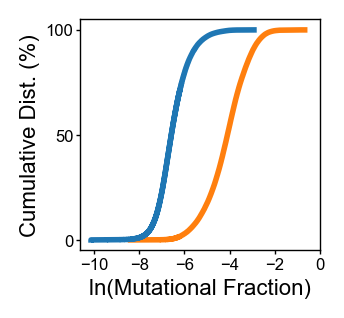

In [26]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_s5b(df1, ax)

In [27]:
df1["ln_r_data"].replace(-np.inf, -10, inplace=True)
df1["ln_r_data"].describe()

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/244418767.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1["ln_r_data"].replace(-np.inf, -10, inplace=True)


count    467835.000000
mean         -5.822457
std           1.317967
min         -10.126631
25%          -6.803395
50%          -6.234811
75%          -4.896860
max          -0.691768
Name: ln_r_data, dtype: float64

In [28]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df1["r_type_binary"] = df1["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df1[["ln_r_data"]], df1["r_type_binary"])
# Compute probabilities for the original data
df1["prob_WC"] = model.predict_proba(df1[["ln_r_data"]])[:, 1]
# Display the probabilities
df1.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type_simple", "prob_WC"]]

,ln_r_data,r_type_simple,prob_WC
157982,-10.126631,WC,1.000000
159018,-10.126631,WC,1.000000
159470,-9.903488,WC,0.999999
330469,-9.903488,WC,0.999999
171003,-9.903488,WC,0.999999
...,...,...,...
463230,-1.013022,NON-WC,0.000006
463197,-0.994414,NON-WC,0.000005
105290,-0.972755,NON-WC,0.000005
105301,-0.853363,NON-WC,0.000004


In [29]:
def plot_figure_s5c(df, ax):
    ax.scatter(df["ln_r_data"], df["prob_WC"], s=1)
    ax.set_ylabel("Probability of WC pair", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    ax.axhline(y=0.5, color="black", linestyle="--", lw=0.75)
    ax.axvline(x=-5.19, color="black", linestyle="--", lw=0.75)
    format_small_plot(ax)
    return ax

In [30]:
# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df1["abs_diff"] = (df1["prob_WC"] - 0.50).abs()

# Find the index of the minimum difference
min_index = df1["abs_diff"].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df1.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-5.137900645142132


<Axes: xlabel='ln(Mutational Fraction)', ylabel='Probability of WC pair'>

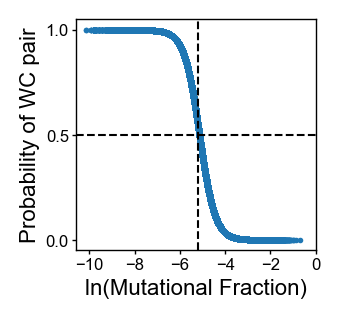

In [31]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_s5c(df1, ax)

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Count (×10³)'>

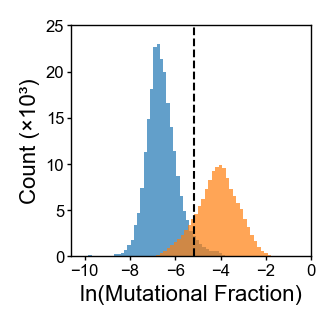

In [32]:
def plot_figure_s5d(df, ax, threshold=-5.19):

    # Plot histogram with two colors
    ax.hist(
        df.query("r_type == 'WC'")["ln_r_data"],
        bins=50,
        color="tab:blue",
        alpha=0.7,
    )
    ax.hist(
        df.query("r_type == 'NON-WC'")["ln_r_data"],
        bins=50,
        color="tab:orange",
        alpha=0.7,
    )

    # Add vertical line at threshold
    ax.axvline(x=threshold, color="black", linestyle="--", linewidth=0.75)

    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_ylabel("Count (×10³)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    ax.set_yticks(
        [0, 5000, 10000, 15000, 20000, 25000], labels=["0", "5", "10", "15", "20", "25"]
    )
    format_small_plot(ax)
    return ax


# Create and save plot
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_s5d(df1, ax)

Subplot 1 dimensions: 1.23" wide x 1.20" tall
Subplot 2 dimensions: 1.23" wide x 1.20" tall
Subplot 3 dimensions: 1.23" wide x 1.20" tall
Subplot 4 dimensions: 1.23" wide x 1.20" tall


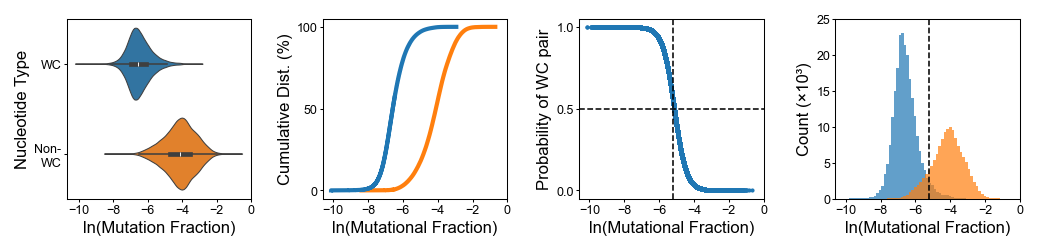

In [33]:
# Create figure with overall size
fig = plt.figure(figsize=(7.00, 1.75), dpi=150)

# Create GridSpec with equal width ratios and spacing between subplots
gs = gridspec.GridSpec(1, 4, figure=fig)

# Add subplots with specified sizes and make them square
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

# Plot figures
plot_figure_s5a(df1, ax1)
plot_figure_s5b(df1, ax2)
plot_figure_s5c(df1, ax3)
plot_figure_s5d(df1, ax4)

# Adjust layout to prevent overlapping
gs.tight_layout(fig, pad=1.0, w_pad=1.10)

# Get and print subplot dimensions after tight_layout
for i, ax in enumerate([ax1, ax2, ax3, ax4], 1):
    bbox = ax.get_position()
    width = bbox.width * fig.get_figwidth()
    height = bbox.height * fig.get_figheight()
    print(f'Subplot {i} dimensions: {width:.2f}" wide x {height:.2f}" tall')

## Supplemental Figure 6: Correlation between WC pairs and six base pair parameters and RMSD from ideal

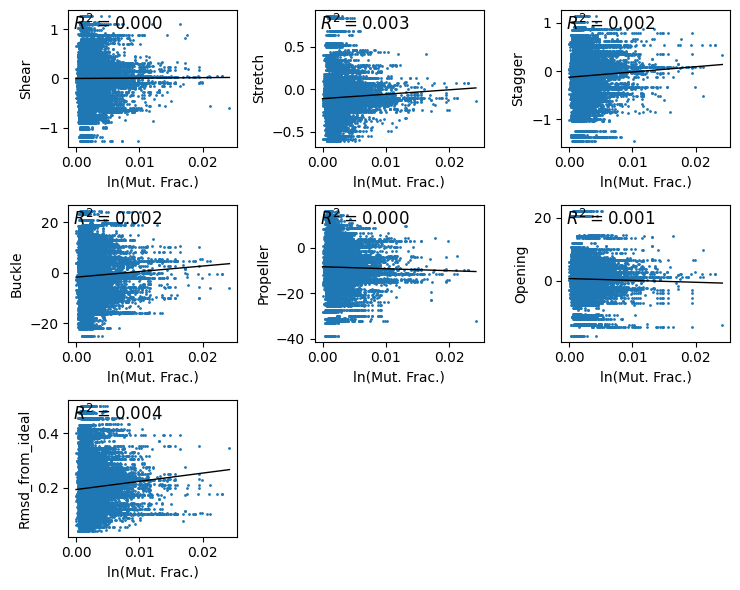

In [34]:
feature_columns = [
    "shear",
    "stretch",
    "stagger",
    "buckle",
    "propeller",
    "opening",
    "rmsd_from_ideal",
]

plot_feature_scatterplots(df_bp_details, feature_columns, "r_data")
plt.tight_layout()

## Supplemental Figure 8: Correlation between SASA 0.5 with ln DMS

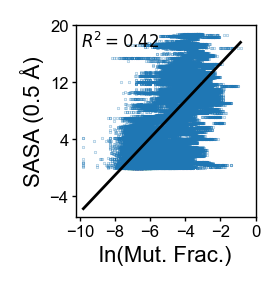

In [35]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plot_scatter_w_best_fit_line(
    df_sasa_merge["ln_r_data"], df_sasa_merge["sasa_0_5"], size=0.01, ax=ax
)
ax.set_xlabel("ln(Mut. Frac.)", labelpad=2)
ax.set_ylabel(f"SASA (0.5 Å)", labelpad=2)
ax.set_yticks([-4, 4, 12, 20])
ax.set_xticks([-10, -8, -6, -4, -2, 0])
format_small_plot(ax)

## Supplemental Figure 9: Impact of neighboring sequences on mismatches

In [36]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [37]:
def plot_fig_sf9(ax1):
    df_cu = df.query(
        "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU'"
    ).copy()
    df_cu["stack_type"] = df_cu.apply(assign_stack_type, axis=1)
    ax1 = plot_violins_w_percent(
        df_cu,
        "ln_r_data",
        "stack_type",
        cutoff=-5.45,
        color=None,
        gt_lt="less",
        xlim=(-10, -1),
        sorted_by_mean=True,
        ax=ax1,
    )
    color_map = {
        "both_purine": "tab:blue",
        "mixed": "tab:orange",
        "both_pyrimidine": "tab:green",
    }

    # Update the colors based on the x-tick labels
    for violin, label in zip(ax1.collections, ax1.get_yticklabels()):
        stack_type = label.get_text()
        if stack_type in color_map:
            violin.set_facecolor(color_map[stack_type])

    ax1.set_ylabel("Stack type")
    ax1.set_xlabel("ln(Mutation Fraction)")
    format_small_plot(ax1)
    return ax1

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


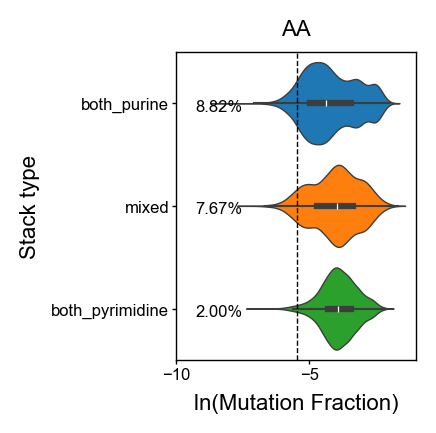

In [38]:
fig, ax2 = plt.subplots(figsize=(2, 2), dpi=200)
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
df_aa["stack_type"] = df_aa.apply(assign_stack_type, axis=1)
ax2 = plot_violins_w_percent(
    df_aa,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax2,
)

color_map = {
    "both_purine": "tab:blue",
    "mixed": "tab:orange",
    "both_pyrimidine": "tab:green",
}

# Update the colors based on the x-tick labels
for violin, label in zip(ax2.collections, ax2.get_yticklabels()):
    stack_type = label.get_text()
    if stack_type in color_map:
        violin.set_facecolor(color_map[stack_type])

ax2.set_ylabel("Stack type")
ax2.set_xlabel("ln(Mutation Fraction)")
ax2.set_title("AA")
format_small_plot(ax2)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


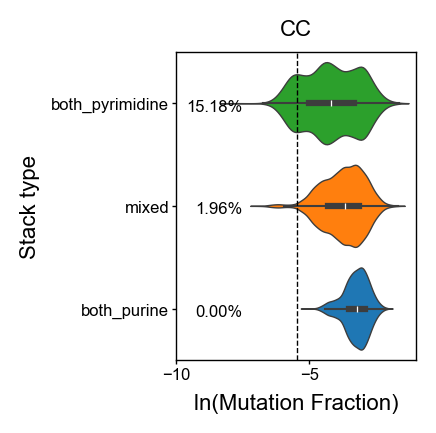

In [39]:
fig, ax3 = plt.subplots(figsize=(2, 2), dpi=200)
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
df_cc["stack_type"] = df_cc.apply(assign_stack_type, axis=1)
ax3 = plot_violins_w_percent(
    df_cc,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax3,
)
color_map = {
    "both_purine": "tab:blue",
    "mixed": "tab:orange",
    "both_pyrimidine": "tab:green",
}
# Update the colors based on the x-tick labels
for violin, label in zip(ax3.collections, ax3.get_yticklabels()):
    stack_type = label.get_text()
    if stack_type in color_map:
        violin.set_facecolor(color_map[stack_type])
ax3.set_ylabel("Stack type")
ax3.set_xlabel("ln(Mutation Fraction)")
ax3.set_title("CC")
format_small_plot(ax3)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


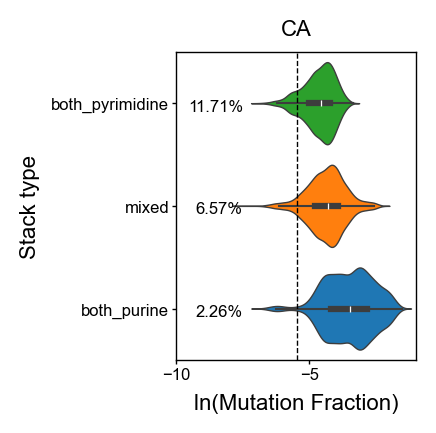

In [40]:
fig, ax4 = plt.subplots(figsize=(2, 2), dpi=200)
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
df_ca["stack_type"] = df_ca.apply(assign_stack_type, axis=1)
ax4 = plot_violins_w_percent(
    df_ca,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax4,
)
color_map = {
    "both_purine": "tab:blue",
    "mixed": "tab:orange",
    "both_pyrimidine": "tab:green",
}
# Update the colors based on the x-tick labels
for violin, label in zip(ax4.collections, ax4.get_yticklabels()):
    stack_type = label.get_text()
    if stack_type in color_map:
        violin.set_facecolor(color_map[stack_type])
ax4.set_ylabel("Stack type")
ax4.set_xlabel("ln(Mutation Fraction)")
ax4.set_title("CA")
format_small_plot(ax4)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


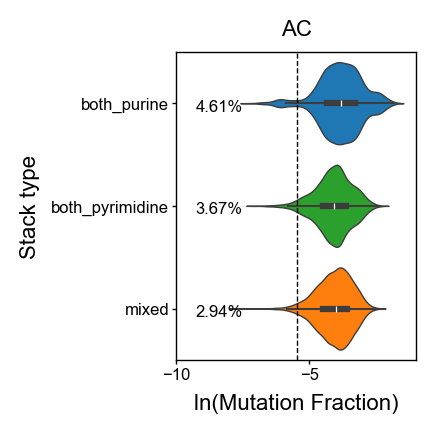

In [41]:
fig, ax5 = plt.subplots(figsize=(2, 2), dpi=200)
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
df_ac["stack_type"] = df_ac.apply(assign_stack_type, axis=1)
ax5 = plot_violins_w_percent(
    df_ac,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax5,
)
color_map = {
    "both_purine": "tab:blue",
    "mixed": "tab:orange",
    "both_pyrimidine": "tab:green",
}
# Update the colors based on the x-tick labels
for violin, label in zip(ax5.collections, ax5.get_yticklabels()):
    stack_type = label.get_text()
    if stack_type in color_map:
        violin.set_facecolor(color_map[stack_type])
ax5.set_ylabel("Stack type")
ax5.set_xlabel("ln(Mutation Fraction)")
ax5.set_title("AC")
format_small_plot(ax5)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


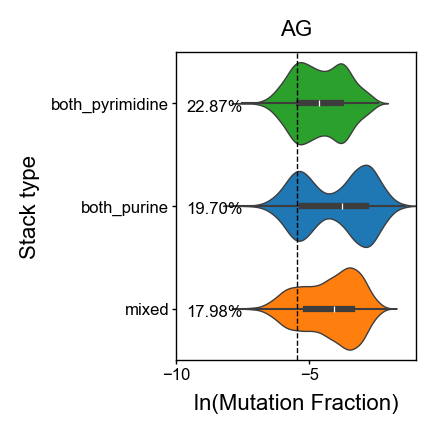

In [42]:
fig, ax6 = plt.subplots(figsize=(2, 2), dpi=200)
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
df_ag["stack_type"] = df_ag.apply(assign_stack_type, axis=1)
ax6 = plot_violins_w_percent(
    df_ag,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax6,
)
color_map = {
    "both_purine": "tab:blue",
    "mixed": "tab:orange",
    "both_pyrimidine": "tab:green",
}
# Update the colors based on the x-tick labels
for violin, label in zip(ax6.collections, ax6.get_yticklabels()):
    stack_type = label.get_text()
    if stack_type in color_map:
        violin.set_facecolor(color_map[stack_type])
ax6.set_ylabel("Stack type")
ax6.set_xlabel("ln(Mutation Fraction)")
ax6.set_title("AG")
format_small_plot(ax6)

## Supplemental Figure 10: Weaker correlations between mismatched pairs and DMS reactivity

Text(698.8061594202899, 0.5, "C-C O3'-C4 Distance")

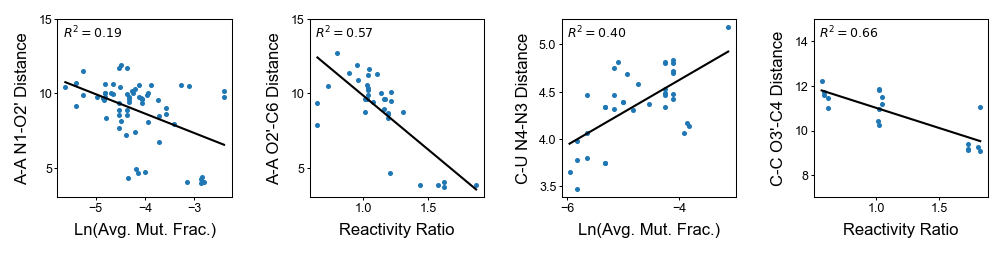

In [45]:
# Create figure with overall size
fig = plt.figure(figsize=(7.00, 1.75), dpi=150)

# Create GridSpec with equal width ratios and spacing between subplots
gs = gridspec.GridSpec(1, 4, figure=fig)

# Add subplots with specified sizes and make them square
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

# Adjust layout to prevent overlapping
gs.tight_layout(fig, pad=1.0, w_pad=0.0)

# A-A distance vs reactivity
df_corr_data_aa = df_dist.query(
    'pair == "A-A" and atom1 == "N1" and atom2 == "O2\'"'
).copy()
df_corr_data_aa.sort_values(by="distance", ascending=False, inplace=True)

plot_scatter_w_best_fit_line(
    df_corr_data_aa["ln_r_data_mean"], df_corr_data_aa["distance"], size=2, ax=ax1
)
format_small_plot(ax1)
ax1.set_ylim(3, 15)
ax1.set_xlabel("Ln(Avg. Mut. Frac.)")
ax1.set_ylabel("A-A N1-O2' Distance")

# A-A ratio vs distance
df_ratio_corr_data_aa = df_ratio.query(
    'pair == "A-A" and atom1 == "O2\'" and atom2 == "C6"'
).copy()
df_ratio_corr_data_aa.sort_values(by="distance", ascending=False, inplace=True)

plot_scatter_w_best_fit_line(
    df_ratio_corr_data_aa["ratio"], df_ratio_corr_data_aa["distance"], size=2, ax=ax2
)
format_small_plot(ax2)
ax2.set_ylim(3, 15)
ax2.set_xlabel("Reactivity Ratio")
ax2.set_ylabel("A-A O2'-C6 Distance")

# C-U distance vs reactivity
df_corr_data_cu = df_dist.query(
    'pair == "C-U" and atom1 == "N4" and atom2 == "N3"'
).copy()
df_corr_data_cu.sort_values(by="distance", ascending=False, inplace=True)

plot_scatter_w_best_fit_line(
    df_corr_data_cu["ln_r_data_mean"], df_corr_data_cu["distance"], size=2, ax=ax3
)
format_small_plot(ax3)
ax3.set_xlabel("Ln(Avg. Mut. Frac.)")
ax3.set_ylabel("C-U N4-N3 Distance")

# C-C ratio vs distance
df_ratio_corr_data_cc = df_ratio.query(
    'pair == "C-C" and atom1 == "O3\'" and atom2 == "C4"'
).copy()
df_ratio_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)

plot_scatter_w_best_fit_line(
    df_ratio_corr_data_cc["ratio"], df_ratio_corr_data_cc["distance"], size=2, ax=ax4
)
format_small_plot(ax4)
ax4.set_ylim(7, 15)
ax4.set_xlabel("Reactivity Ratio")
ax4.set_ylabel("C-C O3'-C4 Distance")

# Save figure
#plt.savefig(
#    "../../figures/supplemental_figures/supplemental_figure_10.png",
#    dpi=600,
#    bbox_inches="tight",
#    pad_inches=0.02,
#)

## Supplemental Figure 11: Correlation plots of the top 10 atomic pair correlations for A-G pairs

In [46]:
df_dist_ag = df_dist.query('pair == "A-G" and ln_r_data_mean != ""').copy()

In [47]:
df_unique = df_dist_ag.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"])
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_unique

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/1304277941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.sort_values(by="r2", ascending=False, inplace=True)


,pdb_name,pdb_r_pos,pair_pdb_r_pos,pdb_r_bp_type,distance,average_b_factor,normalized_b_factor,pdb_res,ln_r_data_mean,ln_r_data_std,pair,atom1,atom2,r2
2806,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,14.40,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,OP2,P,0.518570
5002,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,7.62,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,OP2,C6,0.509953
2196,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,8.92,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,P,C6,0.507597
0,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,15.61,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,P,P,0.506871
4880,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,8.43,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,OP2,C5,0.506294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60367,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,7.83,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,N9,N1,0.000248
61343,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,10.34,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,N9,N7,0.000069
36455,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,12.31,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,C2,P,0.000058
46947,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,7.46,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,C5,C5,0.000006


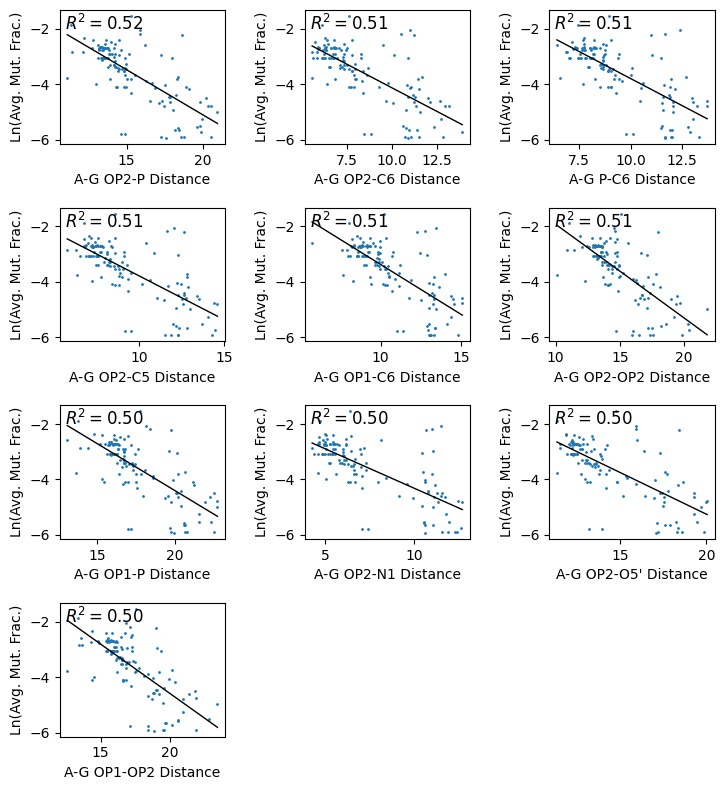

In [48]:
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(3)

n_plots = 10
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
for idx, (i, row) in enumerate(df_top_10.iterrows()):
    row_pos = idx // n_cols
    col_pos = idx % n_cols
    ax = axes[row_pos, col_pos] if n_rows > 1 else axes[col_pos]
    df_plot = df_dist.query(f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"').copy()
    plot_scatter_w_best_fit_line(df_plot["distance"], df_plot["ln_r_data_mean"], size=1,ax=ax)
    ax.set_xlabel(f"A-G {row["atom1"]}-{row["atom2"]} Distance")
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
plt.tight_layout()

for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

## Supplemental Figure 12: Correlation plots of the top 10 atomic pair correlations for C-A pairs

In [49]:
df_dist_ca = df_dist.query('pair == "C-A" and ln_r_data_mean != ""').copy()

In [50]:
df_unique = df_dist_ca.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"])
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_unique

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/2576896327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.sort_values(by="r2", ascending=False, inplace=True)


,pdb_name,pdb_r_pos,pair_pdb_r_pos,pdb_r_bp_type,distance,average_b_factor,normalized_b_factor,pdb_res,ln_r_data_mean,ln_r_data_std,pair,atom1,atom2,r2
103903,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,12.91,27.956,7.740498,2.0,-4.566327,0.191779,C-A,O3',C2',0.513945
102847,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,12.41,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C3',C2',0.496360
103855,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,12.61,27.956,7.740498,2.0,-4.566327,0.191779,C-A,O3',C1',0.491298
104095,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,9.63,27.956,7.740498,2.0,-4.566327,0.191779,C-A,O3',N3,0.476819
105967,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,10.62,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C2',C1',0.464466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114031,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,14.20,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C5,OP2,0.000105
115135,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,16.82,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C6,OP1,0.000088
115759,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,9.33,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C6,C4,0.000025
115039,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,15.49,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C6,P,0.000020


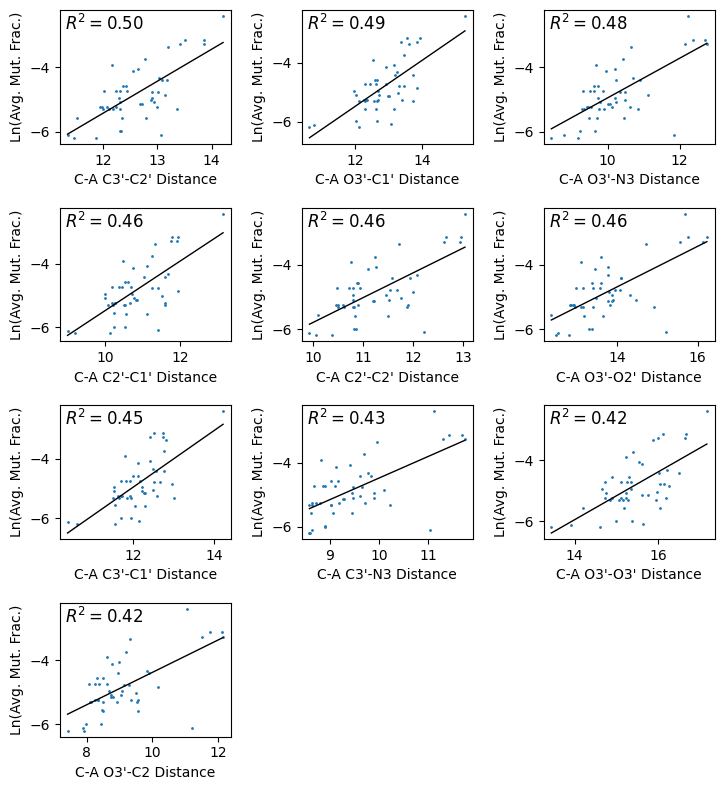

In [51]:
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(0)

n_plots = 10
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
for idx, (i, row) in enumerate(df_top_10.iterrows()):
    row_pos = idx // n_cols
    col_pos = idx % n_cols
    ax = axes[row_pos, col_pos] if n_rows > 1 else axes[col_pos]
    df_plot = df_dist.query(f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"').copy()
    plot_scatter_w_best_fit_line(df_plot["distance"], df_plot["ln_r_data_mean"], size=1,ax=ax)
    ax.set_xlabel(f"C-A {row["atom1"]}-{row["atom2"]} Distance")
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
plt.tight_layout()

for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

## Supplemental Figure 13: Correlation plots of the top 10 atomic pair correlations for A-C pairs

In [52]:
df_ratio_ca = df_ratio.query('pair == "C-A"').copy()

In [53]:
df_unique = df_ratio_ca.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"])
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_unique

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/1501704007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.sort_values(by="r2", ascending=False, inplace=True)


,pdb_name,pdb_r_pos,pair_pdb_r_pos,distance,pdb_res,ratio,pair,atom1,atom2,r2
28560,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,14.53,2.0,1.068473,C-A,O2',OP2,6.532282e-01
27504,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,14.47,2.0,1.068473,C-A,C2',OP2,6.452397e-01
31728,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,11.48,2.0,1.068473,C-A,O2,OP2,6.301218e-01
28512,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,15.17,2.0,1.068473,C-A,O2',P,6.265924e-01
25392,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,16.73,2.0,1.068473,C-A,O3',OP2,6.107122e-01
...,...,...,...,...,...,...,...,...,...,...
36816,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,8.98,2.0,1.068473,C-A,C5,N7,6.530388e-05
27024,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,6.56,2.0,1.068473,C-A,C1',C2,2.666505e-05
19440,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,16.87,2.0,1.068473,C-A,OP1,C1',2.319690e-05
33984,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,12.76,2.0,1.068473,C-A,C4,C5',1.729811e-05


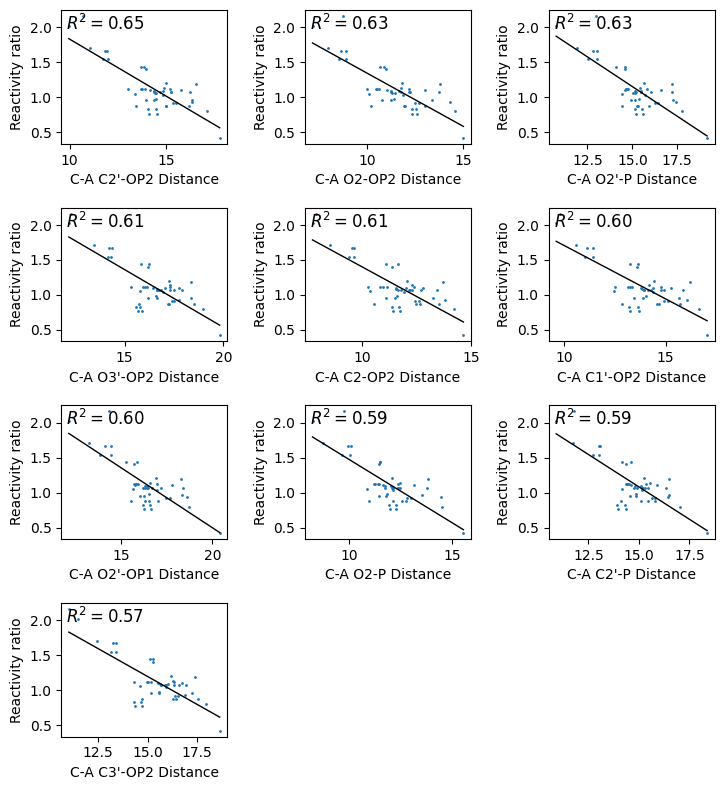

In [54]:
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(0)

n_plots = 10
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
for idx, (i, row) in enumerate(df_top_10.iterrows()):
    row_pos = idx // n_cols
    col_pos = idx % n_cols
    ax = axes[row_pos, col_pos] if n_rows > 1 else axes[col_pos]
    df_plot = df_ratio.query(f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"').copy()
    plot_scatter_w_best_fit_line(df_plot["distance"], df_plot["ratio"], size=1,ax=ax)
    ax.set_xlabel(f"C-A {row["atom1"]}-{row["atom2"]} Distance")
    ax.set_ylabel("Reactivity ratio")
plt.tight_layout()

for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

## Supplemental Figure 14: XXX

## Supplemental Figure 15: Correlation plots of the top 10 atomic pair correlations for C-C pairs

In [55]:
df_dist_cc = df_dist.query('pair == "C-C" and ln_r_data_mean != ""').copy()

In [56]:
df_unique = df_dist_cc.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"])
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_unique

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_13842/1052219050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.sort_values(by="r2", ascending=False, inplace=True)


,pdb_name,pdb_r_pos,pair_pdb_r_pos,pdb_r_bp_type,distance,average_b_factor,normalized_b_factor,pdb_res,ln_r_data_mean,ln_r_data_std,pair,atom1,atom2,r2
121730,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,14.95,44.635,12.722122,3.05,-6.18625,0.278394,C-C,O3',OP2,6.365636e-01
123130,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,12.58,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C2',OP2,6.237035e-01
121030,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,13.90,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C3',OP2,6.182270e-01
123830,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,12.91,44.635,12.722122,3.05,-6.18625,0.278394,C-C,O2',OP2,6.056793e-01
121695,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,15.44,44.635,12.722122,3.05,-6.18625,0.278394,C-C,O3',P,6.000941e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126735,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,10.54,44.635,12.722122,3.05,-6.18625,0.278394,C-C,N3,C5',5.134055e-05
125685,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,6.51,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C2,O2,2.195199e-05
116760,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,13.09,44.635,12.722122,3.05,-6.18625,0.278394,C-C,P,C6,1.381032e-05
125545,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,8.93,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C2,C2',2.261676e-06


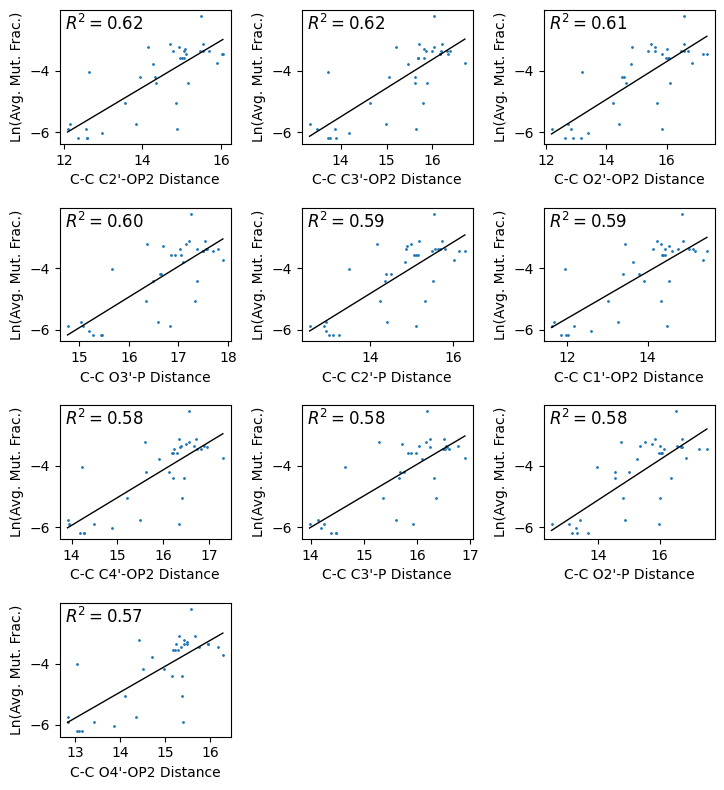

In [57]:
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(0)

n_plots = 10
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
for idx, (i, row) in enumerate(df_top_10.iterrows()):
    row_pos = idx // n_cols
    col_pos = idx % n_cols
    ax = axes[row_pos, col_pos] if n_rows > 1 else axes[col_pos]
    df_plot = df_dist.query(f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"').copy()
    plot_scatter_w_best_fit_line(df_plot["distance"], df_plot["ln_r_data_mean"], size=1,ax=ax)
    ax.set_xlabel(f"C-C {row["atom1"]}-{row["atom2"]} Distance")
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
plt.tight_layout()

for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

## Suppplemental Table 3: Residues under 2 A for SASA

In [58]:
df_non_wc_pair = df_sasa_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)

print(calculate_sasa_percentages(df_non_wc_pair))

| Category   |   Percent_below_2 |   Count |
|:-----------|------------------:|--------:|
| A in A-A   |             23.29 |  992.00 |
| A in A-C   |             62.43 |  668.00 |
| A in A-G   |             69.25 |  374.00 |
| C in C-A   |             51.66 |  664.00 |
| C in C-C   |             12.06 |  506.00 |
| C in C-U   |              0.00 |  521.00 |


## Supplemental Figure XXX: Outliers

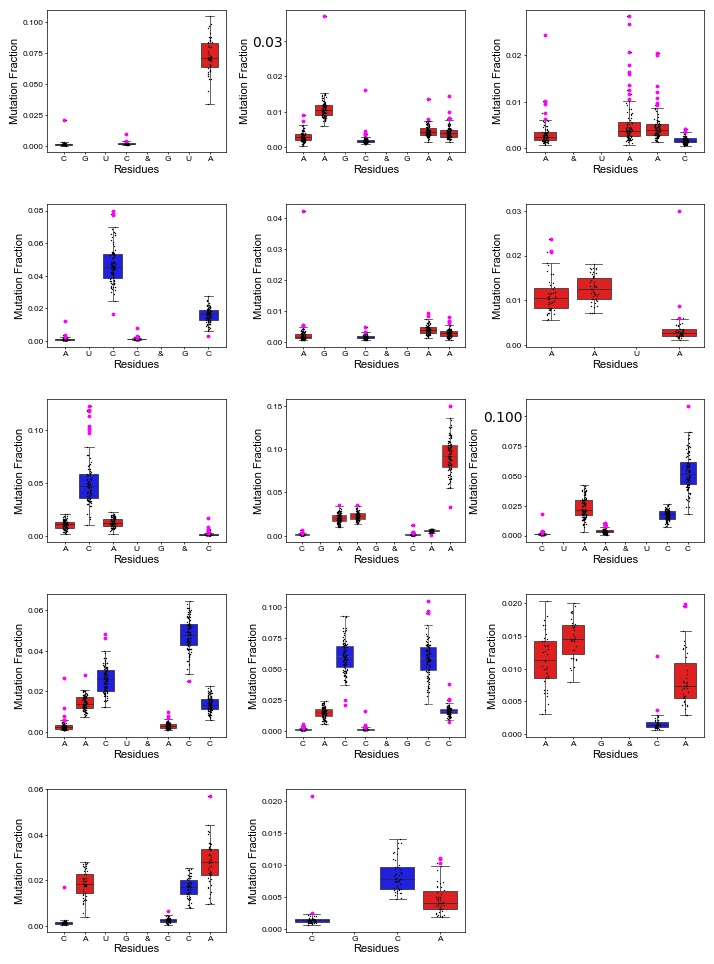

In [59]:
sequences = [
    "CGUC&GUAG",
    "AAGC&GAAU",
    "GGGA&UAAC",
    "AUCC&GCUU",
    "AGGC&GAAU",
    "AAUA&UUGU",
    "ACAUG&CU",
    "CGAAG&CAAG",
    "CUAA&UCCG",
    "AACU&ACCU",
    "CACC&GCCG",
    "UAAG&CA",
    "CAUG&CCAG",
    "CGCA&UUGG",
]

n_plots = len(sequences)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))

axes = axes.flatten()

for i, seq in enumerate(sequences):
    df_motif = df1[df1["m_sequence"] == seq]
    ax = axes[i]
    figure_outlier(df_motif, ax, seq)

for idx in range(n_plots, len(axes)):
    axes[idx].axis("off")

plt.tight_layout(pad=2.0)
plt.show()

## Supplemental Figure XXX: Reactive flanking base pairs for C

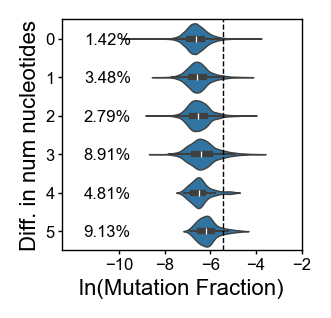

In [60]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
df_pos["side_diff"] = [
    abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]
]
df_pos["side_diff"] = df_pos["side_diff"].astype(str)
df_pos.sort_values("side_diff", inplace=True, ascending=True)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_pos, "ln_r_data", "side_diff", text_offset=0.75, color="tab:blue", ax=ax
)
ax.set_xlim(-12.5, -3)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("Diff. in num nucleotides", labelpad=2)
format_small_plot(ax)

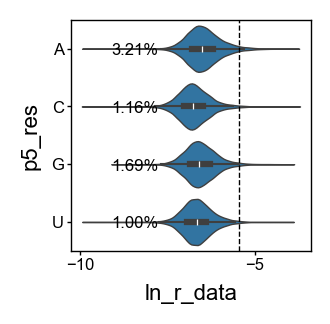

In [61]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "p5_res", color="tab:blue", ax=ax)
format_small_plot(ax)

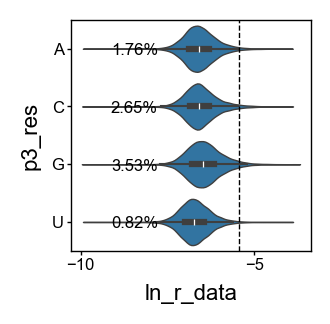

In [62]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "p3_res", color="tab:blue", ax=ax)
format_small_plot(ax)

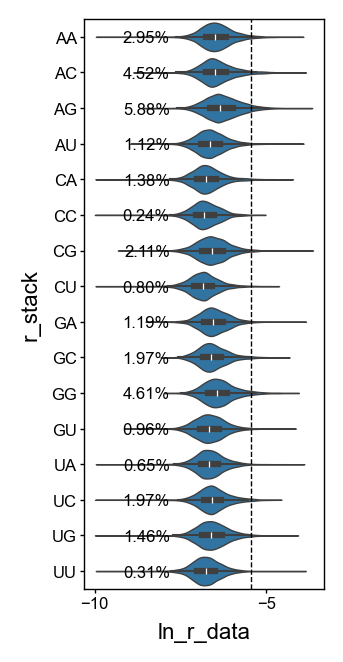

In [63]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 3.7), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "r_stack", color="tab:blue", ax=ax)
format_small_plot(ax)

## Supplemental Figure XXX: Correlation between DMS reactivity and nomod

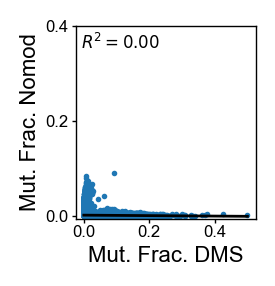

In [64]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mut. Frac. DMS", labelpad=2)
ax.set_ylabel("Mut. Frac. Nomod", labelpad=2)
ax.set_xticks([0.00, 0.20, 0.40])
ax.set_yticks([0.00, 0.20, 0.40])
format_small_plot(ax)

## Supplemental Figure XXX: reactivity vs standard dev

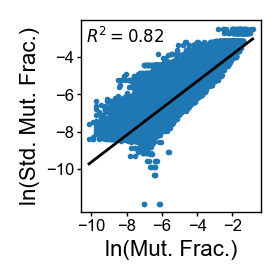

In [68]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0 or np.isnan(std):
        continue
    for _, row in group.iterrows():
        if row["r_data"] == 0 or np.isnan(row["r_data"]):
            continue
        data.append([row["r_data"], std])

df_data = pd.DataFrame(data, columns=["r_data", "std"])

df_data = df_data[(df_data["r_data"] > 0) & (df_data["std"] > 0)]
df_data["ln_r_data"] = np.log(df_data["r_data"])
df_data["ln_std"] = np.log(df_data["std"])

fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
ax.set_xlabel("ln(Mut. Frac.)", labelpad=2)
ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_yticks([-10, -8, -6, -4, -2])
plot_scatter_w_best_fit_line(df_data["ln_r_data"], df_data["ln_std"], ax=ax)
format_small_plot(ax)